<a href="https://colab.research.google.com/drive/1C7VRyV9v7zw_M8Lqd-ZoPG4D9WCrfOlQ?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
!nvidia-smi

Thu Sep  7 21:56:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P4              13W /  55W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


torch.cuda.amp.autocast(enabled=False)

# REPRODUCE
torch.backends.cudnn.deterministi=True
random.seed(hash('setting random seeds')% 2**32-1)
np.random.seed(hash('improves reproducibility')%2**32-1)
torch.manual_seed(hash("by removing stochasticity")%2**32-1)
torch.cuda.manual_seed_all(hash('so runs are repetable')%2**32-1)

In [3]:
from utils import cuda,device,show__random_img

In [4]:
torch.__version__

'2.0.1+cu118'

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [6]:
train_data = datasets.MNIST('../../data', train=True, download=False, transform=train_transforms)
test_data = datasets.MNIST('../../data', train=False, download=False, transform=test_transforms)

In [7]:
batch_size = 64

if torch.cuda.is_available():
    kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 3, 'pin_memory': True}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

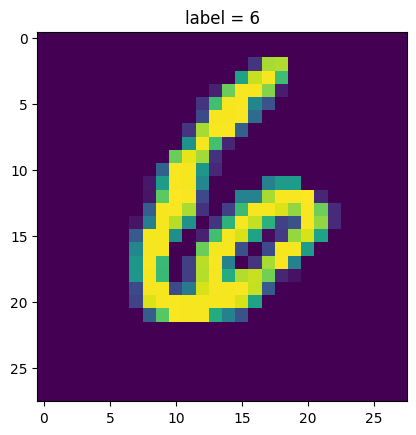

In [9]:
for i in random.choices(np.arange(0,20),k=1):
    plt.imshow(train_data.data[i])
    plt.title(f'label = {train_data.targets[i].numpy()}')
    plt.show()

### Model 1

In [10]:
from model import Net

In [11]:
model = Net().to(device)
# for name,weights in model.named_parameters():
#     print(f"{name}\t\t {weights.shape}")

summary(model=model,input_size=(1,28,28),device='cuda');

optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
criterion =  F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              27
       BatchNorm2d-2            [-1, 3, 28, 28]               6
              ReLU-3            [-1, 3, 28, 28]               0
         Dropout2d-4            [-1, 3, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             216
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
         Dropout2d-8            [-1, 8, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           1,152
      BatchNorm2d-10           [-1, 16, 28, 28]              32
             ReLU-11           [-1, 16, 28, 28]               0
        Dropout2d-12           [-1, 16, 28, 28]               0
        MaxPool2d-13           [-1, 16, 15, 15]               0
           Conv2d-14            [-1, 8,

Train: Loss=0.0881 Batch_id=937 Accuracy=93.44: 100%|██████████| 938/938 [00:10<00:00, 87.10it/s] 


Test set: Average loss: 0.0491, Accuracy: 9843/10000 (98.4300%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 2


Train: Loss=0.0430 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:10<00:00, 89.18it/s] 


Test set: Average loss: 0.0389, Accuracy: 9884/10000 (98.8400%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 3


Train: Loss=0.0082 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:10<00:00, 87.58it/s] 


Test set: Average loss: 0.0386, Accuracy: 9879/10000 (98.7900%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 4


Train: Loss=0.0653 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:10<00:00, 89.32it/s] 


Test set: Average loss: 0.0326, Accuracy: 9897/10000 (98.9700%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 5


Train: Loss=0.0071 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:10<00:00, 88.18it/s] 


Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.1500%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 6


Train: Loss=0.0393 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:10<00:00, 88.46it/s] 


Test set: Average loss: 0.0200, Accuracy: 9927/10000 (99.2700%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 7


Train: Loss=0.1257 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:10<00:00, 89.31it/s] 


Test set: Average loss: 0.0189, Accuracy: 9935/10000 (99.3500%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 8


Train: Loss=0.0065 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:10<00:00, 89.93it/s] 


Test set: Average loss: 0.0189, Accuracy: 9935/10000 (99.3500%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 9


Train: Loss=0.0046 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:10<00:00, 87.80it/s] 


Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.3900%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 10


Train: Loss=0.0048 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:10<00:00, 88.88it/s] 


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.4100%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 11


Train: Loss=0.0129 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:10<00:00, 90.11it/s] 


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.4100%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 12


Train: Loss=0.0212 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:10<00:00, 88.36it/s] 


Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.4000%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 13


Train: Loss=0.0405 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:10<00:00, 87.11it/s] 


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.4200%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 14


Train: Loss=0.0577 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:10<00:00, 88.75it/s] 


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.4300%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 15


Train: Loss=0.0662 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:10<00:00, 87.60it/s] 


Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.4100%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 16


Train: Loss=0.0103 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:10<00:00, 88.92it/s] 


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.4400%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 17


Train: Loss=0.0046 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:10<00:00, 91.03it/s] 


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.4200%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 18


Train: Loss=0.0664 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:10<00:00, 91.15it/s] 


Test set: Average loss: 0.0178, Accuracy: 9940/10000 (99.4000%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 19


Train: Loss=0.0383 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:10<00:00, 91.30it/s] 


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.4200%)

Adjusting learning rate of group 0 to 2.0000e-04.
Epoch 20


Train: Loss=0.0065 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:10<00:00, 90.76it/s] 


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.4600%)

Adjusting learning rate of group 0 to 2.0000e-05.


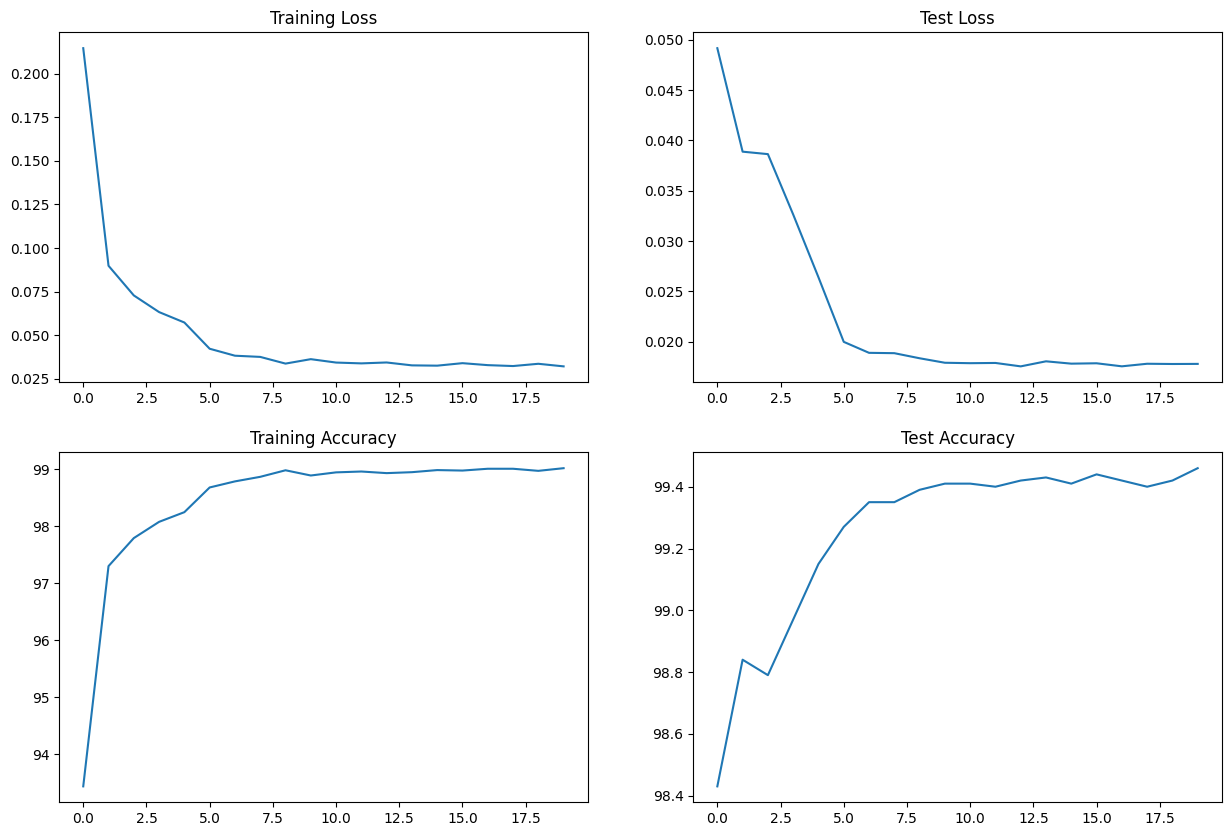

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [3]:
from utils import calculate_mean_std_mnist
mnist_data = datasets.MNIST( root='../../data', download=True, transform=transforms.ToTensor() ,)
mean,std= calculate_mean_std_mnist(mnist_data)

print(mean,std)

0.13065974414348602 0.3015038073062897
